This notebook recreates our TTCT Figural classification on the MTCI data from the recent AuDrA paper.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install transformers[torch] datasets evaluate wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


See the image classification [task page](https://huggingface.co/tasks/image-classification) for more information about its associated models, datasets, and metrics.

In [3]:
from datasets import load_dataset, Image, Dataset, DatasetDict
from transformers import DefaultDataCollator, AutoImageProcessor
from pathlib import Path

import torch.nn.functional as f
import torch
import os

from PIL import Image as PILImage
import wandb
import pandas as pd
import numpy as np

import json
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

## Prep the data

Some comments:
- ViT and BEiT have a base size (86M) and a large size (307M).
   - in the [BEiT](https://arxiv.org/pdf/2106.08254.pdf) paper, B->L tends to be 2-2.5pt improvement for both BEiT and ViT. (Table 1)
- regular resolution of ViT, BEiT, ConvNext is 224. VIT and BEiT also have resolution of 384.
   - In the BEiT paper, 224->384 is about 1-1.5pt improvement for both models.
   - I expect that for doodles, the improvment will be lower, since they don't need much resolution.
- Most common training data is ImageNet 1k and ImageNet-22k.

In [4]:
wd = Path('/content/drive/MyDrive/Projects/motes-figural') #@param {type:"raw"}
project_data_dir = wd / 'data' #@param {type:"raw"}
#img_dir = wd / 'extracted_content'
#gt_dir = wd / 'img_ground_truth'

seed = 1234 #@param {type:"integer"}
name = "motes_mtci" #@param {type:"string"}
classification_model = "microsoft/beit-large-patch16-224-pt22k-ft22k" #@param ["google/vit-large-patch16-224", "microsoft/beit-large-patch16-224-pt22k-ft22k", "facebook/convnext-base-224", "microsoft/resnet-50", "google/vit-base-patch16-384", "microsoft/beit-base-patch16-224-pt22k-ft22k", "google/vit-base-patch16-224"]
%env WANDB_PROJECT=$name

modeldir = project_data_dir / 'models' / (name+'_'+classification_model.replace('/','-'))
modeldir.mkdir(exist_ok=True)


env: WANDB_PROJECT=motes_mtci


### General Prep

In [15]:
data_dir = Path('/content/drive/MyDrive/data/others/audra')

In [16]:
# doublecheck that this is the analysis data
collector = []
for csvfile in (data_dir / 'Analysis').glob('*_revised.csv'):
    if 'rg' in csvfile.stem:
        x = pd.read_csv(csvfile, index_col=0)
        for col in ['ratings', 'predictions','ink']:
            x[col] = x[col].apply(lambda x: json.loads(x)[0])
    else:
        x = pd.read_csv(csvfile)
    x['dataset'] = csvfile.stem.split('_')[0]
    collector.append(x)
analysis_data = pd.concat(collector)
analysis_data.groupby('dataset').corr(numeric_only=True).iloc[1::2, 0].round(2)

dataset                
rg1         predictions    0.76
rg2         ratings        1.00
            ink            0.33
test        predictions    0.80
training    ratings        1.00
            ink            0.52
validation  predictions    0.81
Name: ratings, dtype: float64

In [17]:
def calc_metrics(df, truth_col, pred_col):
    """Calculate PearsonR, MSE, RMSE, R^2 for a given dataset."""
    truth = df[truth_col]
    pred = df[pred_col]
    pearsonr_corr, pval = pearsonr(truth, pred)
    mse = mean_squared_error(truth, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(truth, pred)
    return pd.Series({'r':pearsonr_corr, 'r_pval':pval, 'mse':mse, 'rmse':rmse, 'R2': r2})

analysis_data.groupby('dataset').apply(lambda x: calc_metrics(x, 'predictions', 'ratings'))

,r,r_pval,mse,rmse,R2
dataset,,,,,
rg1,0.759084,1.195412e-126,0.033532,0.183117,-0.865574
rg2,0.651273,2.334898e-88,0.022319,0.149397,-0.763542
test,0.801632,0.000000e+00,0.008840,0.094022,0.445203
training,0.993235,0.000000e+00,0.000315,0.017740,0.986424
validation,0.811575,1.827700e-259,0.008903,0.094357,0.443635


<Axes: >

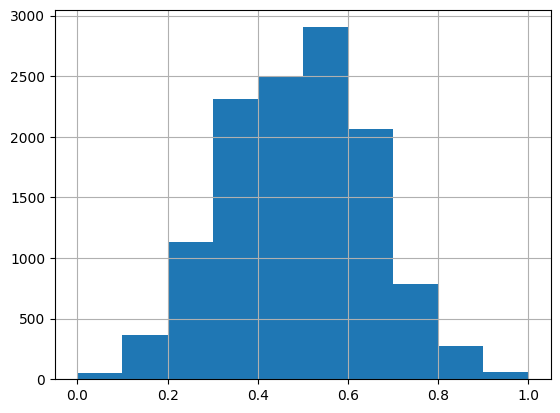

In [18]:
analysis_data.ratings.hist()

The data above matches the paper. Both revision 1 and the newest version of the AuDrA paper.

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
collector = []
# JRT uses the judge response theory data
for csvfile in (data_dir / 'Ratings/JRT').glob('*csv'):
    x = pd.read_csv(csvfile, names=['ID', 'score'])
    x['dataset'], x['style'] = csvfile.stem.split('_')
    collector.append(x)
jrt_data = pd.concat(collector)
display(jrt_data.dataset.value_counts())
jrt_data.sample(2)

jrt_data['score_norm'] = scaler.fit_transform(jrt_data.score.values.reshape(-1, 1))[:,0]

jrt_data.sample(1)

primary    11075
rg2          722
fg           679
rg1          670
Name: dataset, dtype: int64

,ID,score,dataset,style,score_norm
10313,10314_13,1.057172,primary,jrt,0.659483


In [20]:
# download images - rather than accessing from GDrive, for faster read downstream (I hope!)
download = True
if download:
    if not Path('drawings.zip').exists():
        !wget -O drawings.zip https://osf.io/download/9bu3a/
    !unzip -u drawings.zip
    drawings = Path('/content/AuDrA Drawings').glob('**/*jpg')
else:
    drawings = (data_dir / 'drawings').glob('**/*jpg')

Archive:  drawings.zip


In [21]:
rows = []
dataset_key = {'primary_images': 'primary', 'rater_generalization_one_images':'rg1',
                'rater_generalization_two_images':'rg2', 'far_generalization_images':'fg'}
for impath in drawings:
    rows.append(dict(img_path=impath,
                     ID=impath.stem,
                     activity=impath.parent.stem,
                     dataset=dataset_key[impath.parent.parent.stem]
                     )
    )

imdata = pd.DataFrame(rows)
data = jrt_data.merge(imdata)
# id-encode activity
activities = data['activity'].unique().tolist()
id2activity = {i:x for i, x in enumerate(activities)}
activity2id = {x:i for i, x in enumerate(activities)}
data['activity_id'] = data.activity.replace(activity2id)
data.sample()

,ID,score,dataset,style,score_norm,img_path,activity,activity_id
3205,1135_13,-0.395471,primary,jrt,0.424735,/content/AuDrA Drawings/primary_images/Images_...,Images_13,11


<Axes: ylabel='Density'>

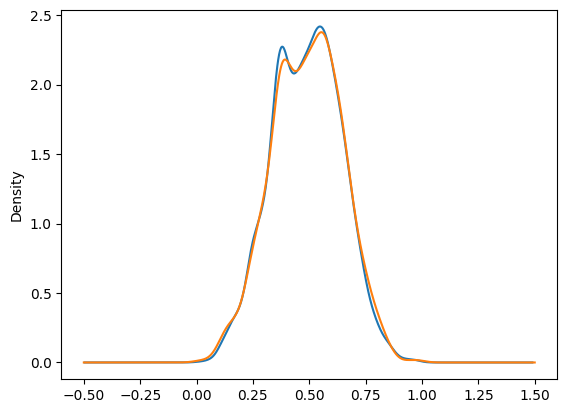

In [22]:
# compare dist of test/val data to all data
ax= jrt_data[jrt_data.dataset == 'primary'].score_norm.plot(kind='density')
analysis_data[analysis_data.dataset.isin(['test', 'validation'])].ratings.plot(kind='density', ax=ax)

In [23]:
rng = np.random.default_rng(seed=seed)
val_prop = 0.1
test_prop = 0.2

data['split'] = 'train'
just_primary = data.dataset == 'primary'
randv = rng.random(size=len(data))
randv[~just_primary] = 0

data.loc[(randv < test_prop+val_prop), 'split'] = 'val'
data.loc[(randv < test_prop), 'split'] = 'test'

data.groupby(['dataset']).split.apply(lambda x: x.value_counts() / len(x)).round(2)

dataset       
fg       test     1.0
primary  train    0.7
         test     0.2
         val      0.1
rg1      test     1.0
rg2      test     1.0
Name: split, dtype: float64

In [24]:
# Create dataset and select only 'primary' data
datasets = {}
for split in ['test', 'train', 'val']:
    subset = data[(data.split == split) & (data.dataset == 'primary')]
    datasets[split] = Dataset.from_dict({'image': subset.img_path.astype(str),
                                         'activity': subset.activity_id.astype(int),
                                         'label': subset.score_norm}).cast_column("image", Image()).shuffle(seed=seed)

rawdataset = DatasetDict(datasets)
rawdataset

DatasetDict({
    test: Dataset({
        features: ['image', 'activity', 'label'],
        num_rows: 2191
    })
    train: Dataset({
        features: ['image', 'activity', 'label'],
        num_rows: 7796
    })
    val: Dataset({
        features: ['image', 'activity', 'label'],
        num_rows: 1088
    })
})

### Model-Specific Prep

Transformations and normalization

In [25]:
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, Resize, Compose, Normalize, ToTensor, RandomInvert
import warnings

one_hot = False #@param {type:"boolean"}
if one_hot:
    warnings.warn("The current one-hot strategy likely won't make a difference because of the patches in VITs. A better strategy would be to change the token in the feature extraction")
invert_prob = 0 #@param {type:"slider", min:0, max:1, step:0.5}
random_crop = False #@param {type:"boolean"}
random_hflip = False #@param {type:'boolean'}

image_processor = AutoImageProcessor.from_pretrained(classification_model)
if "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
else:
    size = (image_processor.size["height"], image_processor.size["width"])
print("image size:", size)

pipeline = []
normalize = Normalize(mean=image_processor.image_mean,
                      std=image_processor.image_std)

if random_crop:
    pipeline.append(RandomResizedCrop(size))
else:
    pipeline.append(Resize(size))

if random_hflip:
    pipeline.append(RandomHorizontalFlip(p=0.5))

if invert_prob > 0:
    pipeline.append(RandomInvert(p=invert_prob)) # possibly force it to look for signal beyond ink

pipeline += [ToTensor(), normalize]
_transforms = Compose(pipeline)

def one_hot_pad(input):
    pixel_values, activity = input
    pixel_values[:, :len(activities), 0] = f.one_hot(torch.tensor(activity), num_classes=len(activities))
    return pixel_values

one_hot_transform = Compose([one_hot_pad])

def transforms(examples, one_hot=False):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    if one_hot:
        examples["pixel_values"] = [one_hot_transform((px, act)) for px, act in zip(examples['pixel_values'], examples['activity'])]
    del examples["image"]
    del examples['activity']
    return examples

dataset = rawdataset.with_transform(lambda x: transforms(x, one_hot))

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


image size: (224, 224)


## Train

In [26]:
import numpy as np
import evaluate
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback

In [27]:
mse = evaluate.load("mse")
pearson = evaluate.load("pearsonr")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = logits.squeeze()
    metrics = {}
    metrics.update(mse.compute(predictions=logits, references=labels))
    metrics.update(pearson.compute(predictions=logits, references=labels))
    # the evaluate module for r_squared is inconsistent, just use scipy module
    metrics['r2'] = r2_score(logits, labels)
    metrics['rmse'] = np.sqrt(metrics['mse'])

    return metrics

In [34]:
resume_from_checkpoint = True #@param {type: 'boolean'}
!ls {modeldir}
#@markdown Path is ignored if not resuming
path_to_checkpoint = modeldir / 'checkpoint-575' #@param {type: 'raw'}
if resume_from_checkpoint:
    assert path_to_checkpoint.exists(), f"{path_to_checkpoint} does not exist"
#@markdown may just want to re-init Trainer, without training more
train = False #@param {type: 'boolean'}
evaluate_model = True #@param {type: 'boolean'}
resume_wandb_id = 'vxlho5s5' #@param {type: 'string' }
if not resume_from_checkpoint:
    resume_wandb_id = None
    if not train:
        print("Forcing train, since you're not resuming from checkpoint")
        train = True
if resume_wandb_id:
    print("Resuming Wandb run. Don't accidentally do this if you don't mean to")

checkpoint-500	checkpoint-550	checkpoint-575
Resuming Wandb run. Don't accidentally do this if you don't mean to


In [38]:
# Init model
model = AutoModelForImageClassification.from_pretrained(
    classification_model if not resume_from_checkpoint else path_to_checkpoint,
    num_labels=1,
    ignore_mismatched_sizes=True # without this, it has the original classifier's n(classes) from ImageNet
)

The warning you get about a shape mismatch is correct - the models were trained on ImageNet classes (e.g. on the 21841 classes of ImageNet 22k), and we're removing that classification layer and instead predicting one continuous variable (originality).

In [39]:
epochs = 12
#log_times_per_epoch = 5 # approx. used to set logging_steps

# this is based off the observed limit with my own gpu
if ('384' in classification_model) or ("large" in classification_model):
    # beit-large-224 and vit-large-224 have 307m params, whereas their base models have 86m
    # https://arxiv.org/pdf/2106.08254.pdf
    batch_size = 20
    gradient_accumulation_steps = 8
elif 'convnext-base-224' in classification_model:
    batch_size = 48
    gradient_accumulation_steps = 4
elif '224' in classification_model:
    batch_size = 48
    gradient_accumulation_steps = 4
    #epochs = 12
else:
    batch_size = 16
    gradient_accumulation_steps = 4

# different runs have different batch sizes, so adjust step-based calculated
step_mod = 64*4 / batch_size / gradient_accumulation_steps

# init logging. No pretty names here, I prefer changing names in wandb console
if resume_wandb_id:
    wandb.init(project=name, id=resume_wandb_id)
else:
    wandb.init(project=name)

wandb.config.update({'one-hot':one_hot,
                     'classification_model':classification_model,
                     'seed':seed,
                     'invert_prob':invert_prob,
                     'random_crop':random_crop,
                     'random_hflip': random_hflip})

data_collator = DefaultDataCollator()
training_args = TrainingArguments(
    output_dir=str(modeldir),
    remove_unused_columns=False,

    # evaluate more frequently than epoch
    #evaluation_strategy="epoch",
    #save_strategy="epoch",

    evaluation_strategy="steps",
    eval_steps= int(16 * step_mod),
    #logging_steps=50,

    save_strategy="steps",
    save_steps= int(16 * step_mod),
    save_total_limit=3, #deletes oldest checkpoints

    #use_cpu = False, ######## FOR DEBUGGING
    learning_rate= 5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.2, #% of total steps to warm up (higher is slower)

    num_train_epochs=epochs,
    # log {log_times_per_epoch}, for easier comparison across different runs with different steps configs
    #logging_steps = int(dataset['train'].num_rows/batch_size/gradient_accumulation_steps//log_times_per_epoch),
    logging_steps = int(8 * step_mod),

    load_best_model_at_end=True,
    metric_for_best_model="rmse",
    greater_is_better=False,
    push_to_hub=False, # true if you want to share
    report_to='wandb',
    run_name=modeldir.name
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 7)]
)

if train:
    trainer.train()

if evaluate_model:
    predictions, label_ids, metrics = trainer.predict(dataset['test'], metric_key_prefix='test')
    metrics = {k.replace('test_', 'test/'):v for k,v in metrics.items()}
    wandb.log(metrics)
    print(metrics)

    # Save Results
    results_dir = project_data_dir / 'eval_results' / name
    results_dir.mkdir(exist_ok=True, parents=True)
    fname = results_dir / f"{wandb.run.id}_{wandb.run.name}.csv"
    test_results = pd.DataFrame([predictions[:,0], label_ids], index=['predictions', 'labels']).T
    test_results.to_csv(fname, index=False)

test/loss,▁
test/mse,▁
test/pearsonr,▁
test/r2,▁
test/rmse,▁
test/runtime,▁
test/samples_per_second,▁
test/steps_per_second,▁
test/loss,0.5137
test/mse,0.5137
test/pearsonr,0.05124


{'test/loss': 0.006330175790935755, 'test/mse': 0.006330175934968688, 'test/pearsonr': 0.8554996714765998, 'test/r2': 0.6593688847333881, 'test/rmse': 0.07956240277272103, 'test/runtime': 88.324, 'test/samples_per_second': 24.806, 'test/steps_per_second': 1.245}


| Model         | Epochs     | MSE | R | Link |
|---------------|-----------|------|-----|---|
| google/vit-base-patch16-384 | 7 | 0.010418 | 0.759714 | [WandB](https://wandb.ai/massive-texts/motes_mtci/runs/zohzbksf?workspace=user-porg)


In [41]:
(metrics)

## Inference

Example of using the model, in a `pipeline`:

In [ ]:
# load example image
image = dataset['test']
image[0]

In [ ]:
from transformers import pipeline
path_to_model = "test_model"

classifier = pipeline("image-classification", model=path_to_model)
classifier(image)

[{'score': 0.35574808716773987, 'label': 'beignets'},
 {'score': 0.018057454377412796, 'label': 'chicken_wings'},
 {'score': 0.017733804881572723, 'label': 'prime_rib'},
 {'score': 0.016335085034370422, 'label': 'bruschetta'},
 {'score': 0.0160061065107584, 'label': 'ramen'}]

Or manually, rather than via pipeline:

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch

image_processor = AutoImageProcessor.from_pretrained(path_to_model)
inputs = image_processor(image, return_tensors="pt") # return as pytorch

model = AutoModelForImageClassification.from_pretrained(path_to_model)
with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]